In [1]:
# Imports
import logging
import pandas as pd
import numpy as np
from utilsforecast.plotting import plot_series
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import DistributionLoss
from utilsforecast.preprocessing import fill_gaps
from neuralforecast.utils import augment_calendar_df
from neuralforecast.losses.numpy import smape


In [2]:
import warnings
warnings.filterwarnings('ignore')
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("utilsforecast").setLevel(logging.ERROR)

# Online Retail II Dataset

This dataset contains all transactions (1 mil+ rows) occurring for a UK-based and registered non-store online retail between 01/12/2009 and 09/12/2011. The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

Dataset created by Daqing Chen from the UCI Machine Learning Repository ([source](https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip)).

#### Data Features

| Column Name | Description |
|------------|-------------|
| Invoice | A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. |
| StockCode | A 5-digit integral number uniquely assigned to each distinct product. |
| Description | Product (item) name. |
| Quantity | The quantities of each product (item) per transaction. |
| InvoiceDate | The day and time when a transaction was generated. |
| UnitPrice | Product price per unit in sterling (£). |
| CustomerID | A 5-digit integral number uniquely assigned to each customer. |
| Country | The name of the country where a customer resides. |

#### Define NBEATSx parameters ahead for data filtering requirements

In [3]:
FORECAST_HORIZON = 3
LOOKBACK_WINDOW = 2 * FORECAST_HORIZON
MIN_SERIES_LENGTH = LOOKBACK_WINDOW + FORECAST_HORIZON

#### Load csv and filter cancelled orders

In [4]:
df = pd.read_csv('data/online_sales_dataset.csv')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

#### Let's take a look at the sales dataframe and transform it to the expected format by NeuralForecast, resampling to daily.

In [5]:
# Aggregate by day, fill with zero & rename to ds, unique_id, y per NeuralForecast requirements
df_agg = df.groupby(['InvoiceDate', 'StockCode'])['Quantity'].sum().reset_index()
df_agg.columns = ['ds', 'unique_id', 'y']
df_agg['ds'] = pd.to_datetime(df_agg['ds'])

# filter dataset for complete months only
df_agg = df_agg[df_agg['ds'] < '2011-12-01']

df_agg = df_agg.set_index('ds').groupby(['unique_id']).resample('M')['y'].sum().fillna(0).reset_index()



print(df_agg.head())
print('-------------------------------------')
print('Min Date:', df_agg['ds'].min())
print('Max Date:', df_agg['ds'].max())
print('Number of unique SKUs:', df_agg['unique_id'].nunique())
print('-------------------------------------')

  unique_id         ds     y
0     10002 2009-12-31   216
1     10002 2010-01-31   291
2     10002 2010-02-28   257
3     10002 2010-03-31   642
4     10002 2010-04-30  1132
-------------------------------------
Min Date: 2009-12-31 00:00:00
Max Date: 2011-11-30 00:00:00
Number of unique SKUs: 5298
-------------------------------------


#### Fill gaps in time series data with zeros, per SKU

In [6]:
print(f"Rows before: {len(df_agg)}")
df_complete = fill_gaps(df_agg, freq='M', id_col='unique_id', time_col='ds')

# clip negatives to zero
df_complete['y'] = df_complete['y'].clip(lower=0)

# fill nulls with 0
df_complete['y'] = df_complete['y'].fillna(0)

print(f"Rows after: {len(df_complete)}")
print(f"Gaps filled: {len(df_complete) - len(df_agg)}")
print('-------------------------------------')
print('Null values:')
df_complete.isna().sum()

Rows before: 79619
Rows after: 108037
Gaps filled: 28418
-------------------------------------
Null values:


unique_id    0
ds           0
y            0
dtype: int64

#### Add Calendar features (normalized)

In [7]:
df_enriched, calendar_cols = augment_calendar_df(df=df_complete, freq='M')
print(df_enriched.head())

  unique_id         ds       y     month
0     10002 2009-12-31   216.0  0.500000
1     10002 2010-01-31   291.0 -0.500000
2     10002 2010-02-28   257.0 -0.409091
3     10002 2010-03-31   642.0 -0.318182
4     10002 2010-04-30  1132.0 -0.227273


#### Let's check monthly aggregated sales for the whole dataset to check for seasonality and global trend.

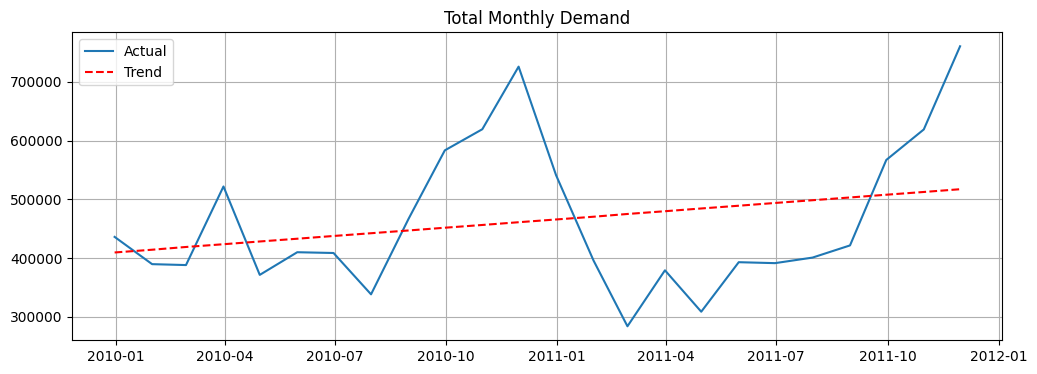

In [8]:
monthly_total = df_enriched.groupby(pd.Grouper(key='ds', freq='M'))['y'].sum()
plt.figure(figsize=(12, 4))
plt.plot(monthly_total.index, monthly_total.values, label='Actual')
x = np.arange(len(monthly_total))
z = np.polyfit(x, monthly_total.values, 1)
p = np.poly1d(z)
plt.plot(monthly_total.index, p(x), "r--", label='Trend')

plt.title('Total Monthly Demand')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
# Filter short time series
n_skus_before = df_enriched['unique_id'].nunique()
df_final = df_enriched.groupby('unique_id').filter(lambda x: len(x) >= MIN_SERIES_LENGTH)
n_skus_after = df_final['unique_id'].nunique()

print(f"Filtered out {n_skus_before - n_skus_after} SKUs with less than {MIN_SERIES_LENGTH} periods of data")
print(f"Remaining SKUs: {n_skus_after}")

Filtered out 586 SKUs with less than 9 periods of data
Remaining SKUs: 4712


#### Split the data into train test dfs

In [10]:
split_date_str = '2011-08-31'
split_date = pd.to_datetime(split_date_str)

df_train = df_final[df_final['ds'] <= split_date]
df_test = df_final[df_final['ds'] > split_date]
print(f"Shapes:\n  Train: {df_train.shape}\n  Test:  {df_test.shape}")
print(f"Ranges:\n  Train: {df_train['ds'].min()} to {df_train['ds'].max()}\n  Test:  {df_test['ds'].min()} to {df_test['ds'].max()}")

Shapes:
  Train: (91309, 4)
  Test:  (14136, 4)
Ranges:
  Train: 2009-12-31 00:00:00 to 2011-08-31 00:00:00
  Test:  2011-09-30 00:00:00 to 2011-11-30 00:00:00


In [11]:
model = NBEATSx(h=FORECAST_HORIZON, 
                input_size=LOOKBACK_WINDOW,
                futr_exog_list=calendar_cols,
                loss=DistributionLoss(distribution='Poisson', level=[10, 25, 50, 75, 90]),
                scaler_type=None,
                max_steps=10000,
                val_check_steps=200,
                learning_rate=0.001,
                early_stop_patience_steps=50,
                enable_progress_bar=True,
                start_padding_enabled=False,
                random_seed=42)

nf = NeuralForecast(
    models=[model],
    freq='M'
)

nf.fit(df=df_train, val_size=3, verbose=True)

Seed set to 42


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [-1:59:59<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

#### Now use the fitted model to predict against our test dates and features

In [12]:
sales_forecast_df = nf.predict(futr_df=df_test)
print('Predict Min Date:', sales_forecast_df['ds'].min())
print('Predict Max Date:', sales_forecast_df['ds'].max())
print(sales_forecast_df.columns)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predict Min Date: 2011-09-30 00:00:00
Predict Max Date: 2011-11-30 00:00:00
Index(['unique_id', 'ds', 'NBEATSx', 'NBEATSx-median', 'NBEATSx-lo-90',
       'NBEATSx-lo-75', 'NBEATSx-lo-50', 'NBEATSx-lo-25', 'NBEATSx-lo-10',
       'NBEATSx-hi-10', 'NBEATSx-hi-25', 'NBEATSx-hi-50', 'NBEATSx-hi-75',
       'NBEATSx-hi-90'],
      dtype='object')


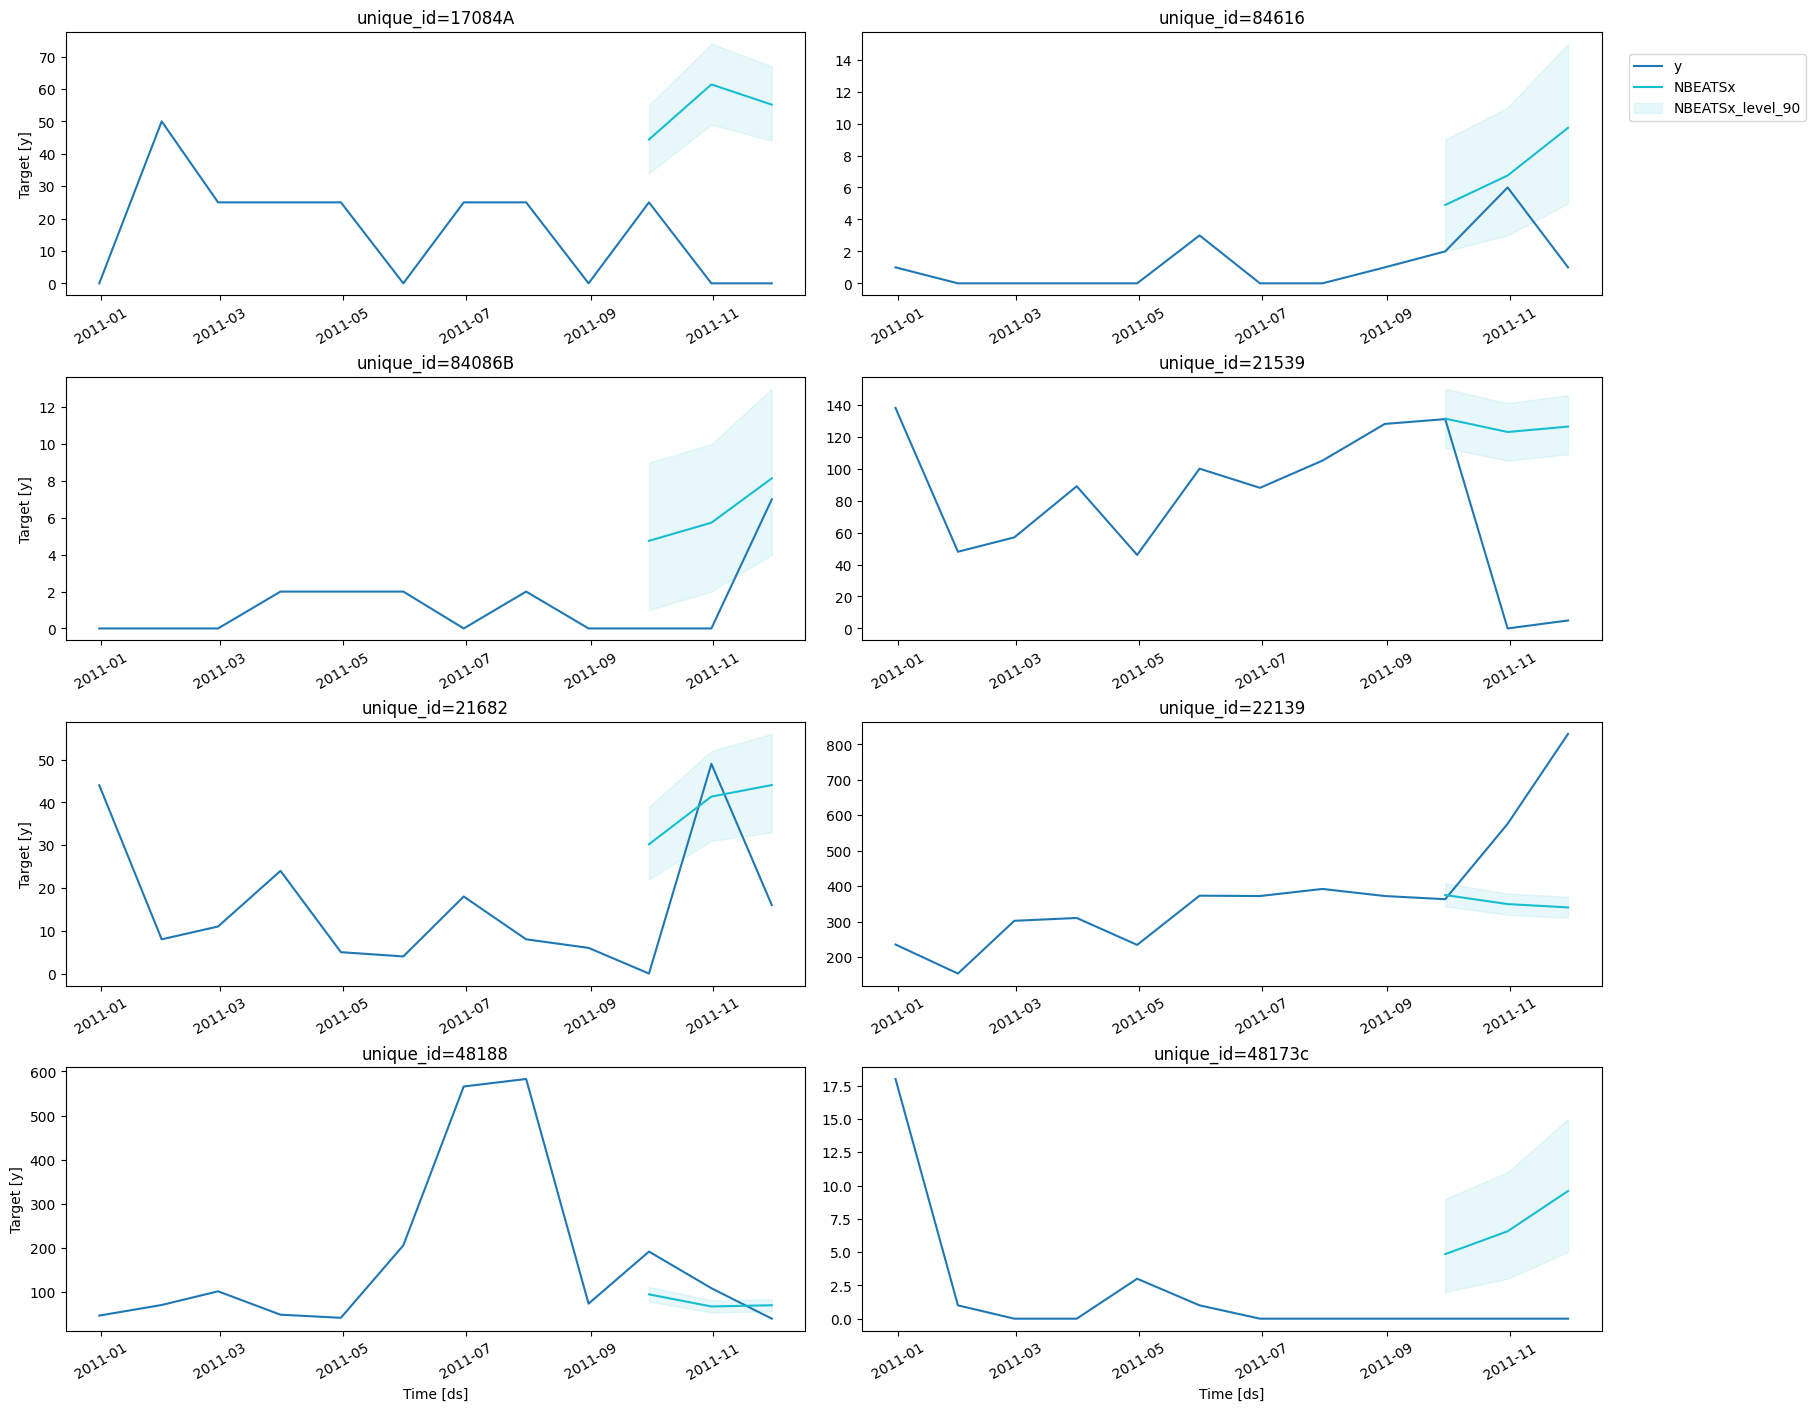

In [19]:
plot_series(
    df_complete, 
    sales_forecast_df,
    plot_random=True, 
    models=["NBEATSx"],
    level=[90],
    max_insample_length=12,
    seed=62
)

#### Calculate accuracy via metric symmetric mean absolute percentage error (sMAPE) across all SKUs

In [20]:
forecast_col = 'NBEATSx'
eval_df = pd.merge(
    df_test[['unique_id', 'ds', 'y']],
    sales_forecast_df[['unique_id', 'ds', forecast_col]],
    on=['unique_id', 'ds'],
    how='inner'
)

smape_value = smape(y=eval_df['y'].values, y_hat=eval_df[forecast_col].values) * 100
print(f"sMAPE: {smape_value:.2f}%")


sMAPE: 140.87%


#### Now lets fit on the full dataset, including test set

In [21]:
nf.fit(df=df_final, val_size=3, verbose=True)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

#### Create future dates with features

In [22]:
future_df = nf.make_future_dataframe()
future_df_enriched, _ = augment_calendar_df(df=future_df, freq='M')
print('Predict Min Date:', future_df_enriched['ds'].min())
print('Predict Max Date:', future_df_enriched['ds'].max())
print(future_df_enriched.columns)

Predict Min Date: 2011-12-31 00:00:00
Predict Max Date: 2012-02-29 00:00:00
Index(['unique_id', 'ds', 'month'], dtype='object')


#### Predict the unseen future

In [23]:
future_forecast_df = nf.predict(futr_df=future_df_enriched)

Predicting: |          | 0/? [00:00<?, ?it/s]

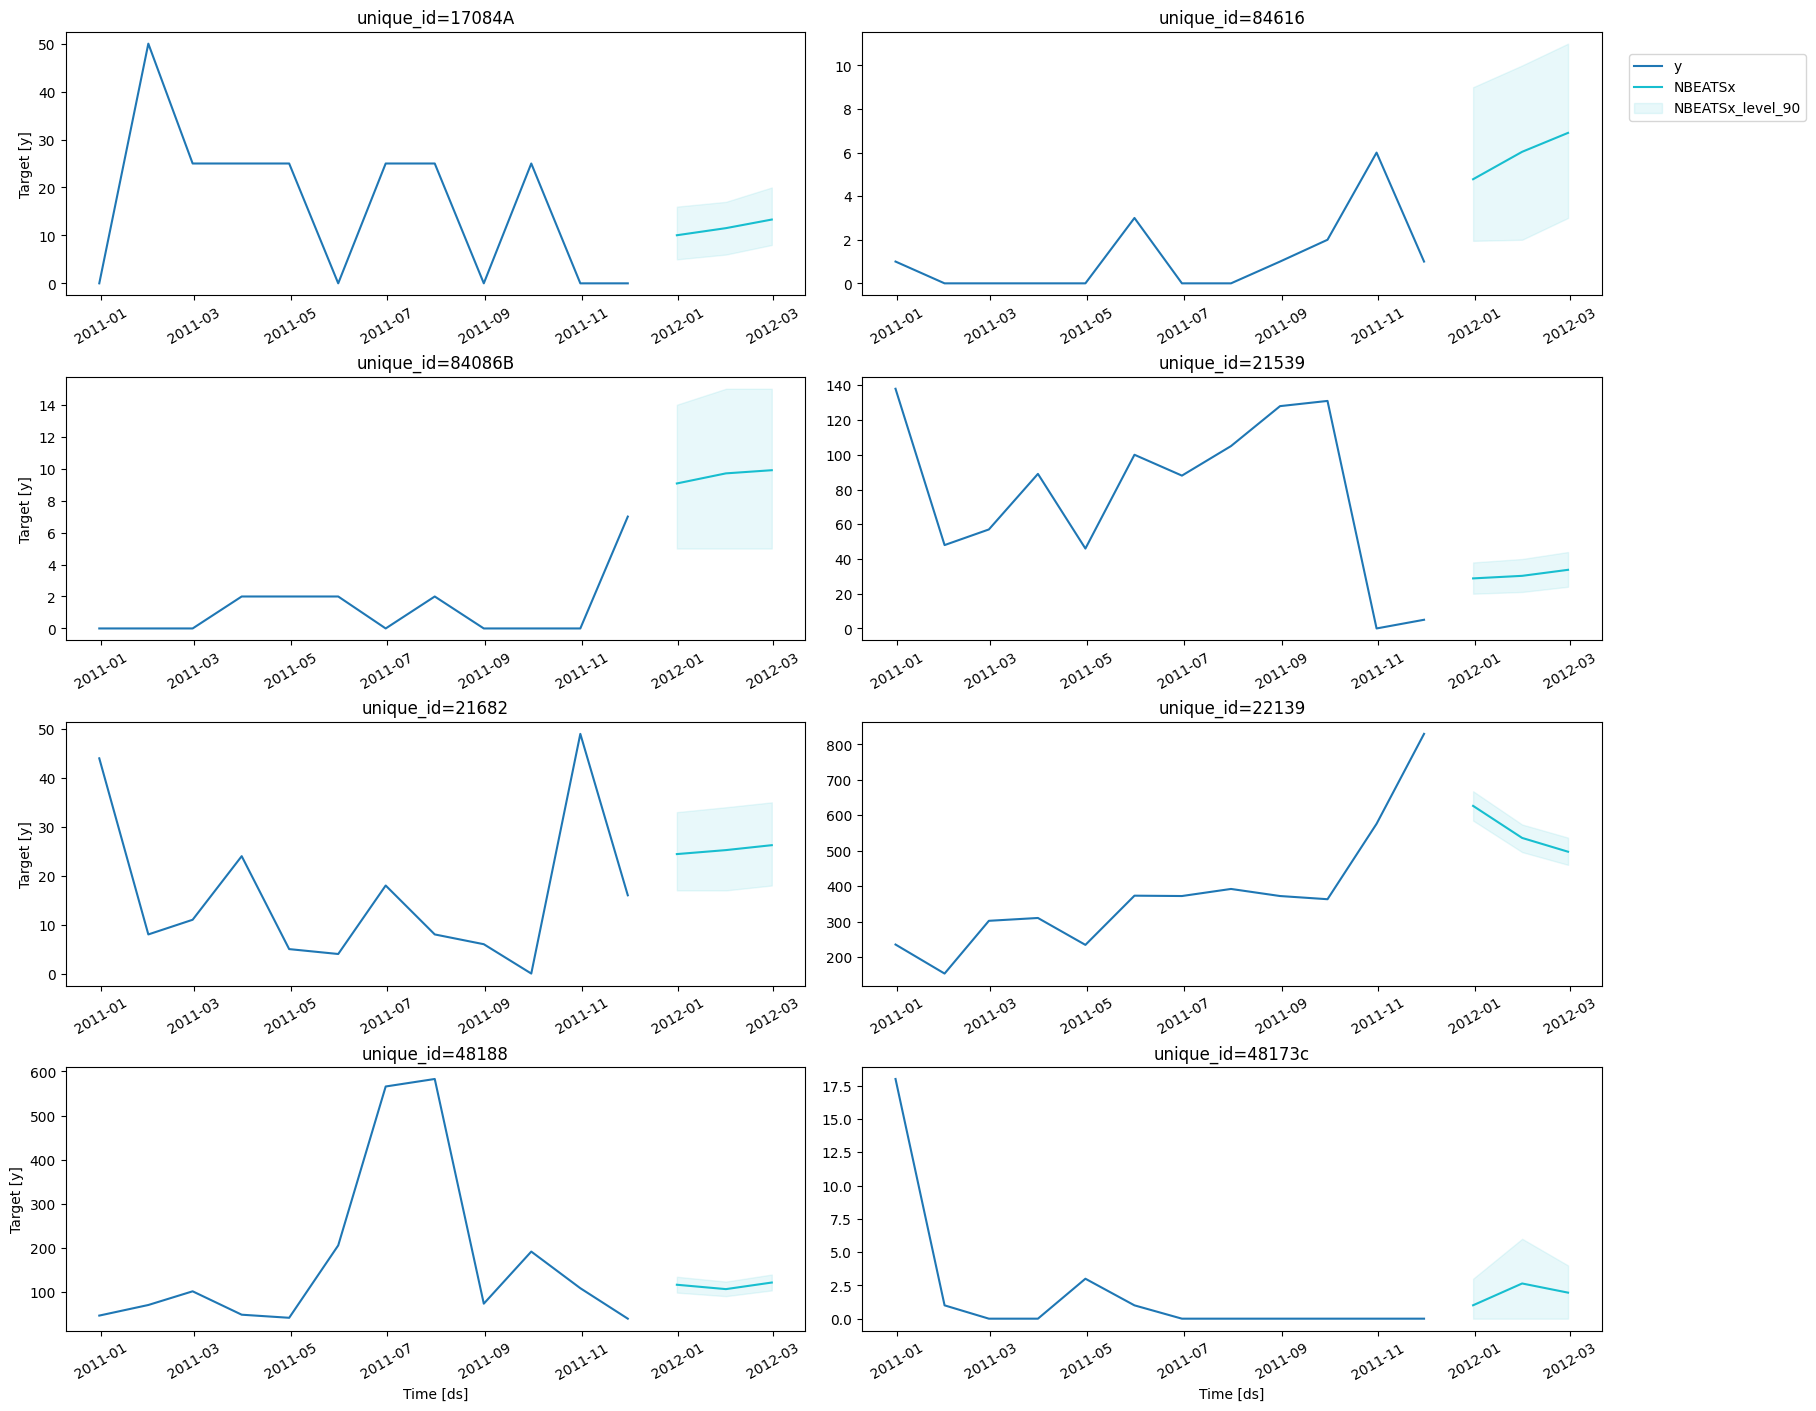

In [24]:
plot_series(
    df_complete, 
    future_forecast_df,
    plot_random=True, 
    models=["NBEATSx"],
    level=[90],
    max_insample_length=12,
    seed=62
)

#### Now lets export the future forecast to CSV

In [25]:
future_forecast_df.to_csv("data/future_forecast.csv", index=False)